<a href="https://colab.research.google.com/github/sobti/TSAI/blob/master/S12/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Mounting Google Colab and importing generic Packages
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensor
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import torchvision
import torch
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose,Cutout)
print(os.getcwd())
drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks\resnet')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/resnet')


/content/gdrive/My Drive/Colab Notebooks/resnet
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#importing self-created packages:
import test_train1 as t                                                         #import train - test module .This is class to train and evaluate the model
import load as ld                                                               #dataloader
import mod_summ as m                                                            #Getting model summary package
import Imagenet_Basic_Block as bb                                                        #Getting Classes for Resnet and Basic Block
import albumm as al                                                            #Getting albumentation module
import override_album as oa                                                     # overriding the albumentation class
import GradCm as gd                                                             #Grad Cam Module
import plot_cam   as pt                                                         #Plotting Image with Gradcam
import lr_update  as lr                                                         #exponential LR update


In [0]:
# RESNET BLOCK
 def ResNet18():
  return bb.ResNet(bb.BasicBlock, [2,2,2,2])
def test():  
  net = ResNet18()
  y = net(torch.randn(1,3,64,64))
  return net

In [8]:
net=test().to('cuda')   
#net=test().to('cpu')
#net=test()
#net=test()#Net - Model to CUDA 
m.summ_print(net,(3,64,64))# Model summary.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
#!unzip tiny-imagenet-200.zip -d '/content/gdrive/My Drive/Colab Notebooks/resnet/imagenet'
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

fatal: destination path 'IMagenet' already exists and is not an empty directory.
test  train  val  wnids.txt  words.txt


In [0]:
val_dir = './IMagenet/tiny-imagenet-200/train'
val_dataset = datasets.ImageFolder(root=val_dir)

In [7]:
print(len(val_dataset))
trainset, testset = torch.utils.data.random_split(val_dataset, [70000, 30000])
trainset1, testset1 = torch.utils.data.random_split(val_dataset, [70000, 30000])

100000


In [0]:
train_transforms,test_transforms=al.album_transform(albumentations)             #Albumentation class 

In [0]:
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                        download=True, transform=None)        
#                                      
#testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                       download=True, transform=None)

In [0]:
# Initialize the dataset, pass the augmentation pipeline as an argument to init function
train_ds = oa.PyTorchImageDataset(image=trainset, augmentations=train_transforms)
test_ds =  oa.PyTorchImageDataset(image=testset, augmentations=test_transforms)           

In [0]:
batch_size=512
trainloader,testloader=ld.load_test_train(batch_size,train_ds,test_ds,torchvision,torch)

In [0]:
def range_test(end_lr=10,num_iter=100,step_mode="exp", smooth_f=0.05, diverge_th=5):
        if step_mode.lower() == "exp":
            lr_schedule = lr.ExponentialLR(optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":         
            lr_schedule = lr.LinearLR(optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")
        return lr_schedule

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
optimizer = optim.SGD(net.parameters(),lr=0.0000000001)                           # start LR is 0.0001
criterion=nn.CrossEntropyLoss()
lr_schedule=range_test(end_lr=10,num_iter=100,step_mode="exp",smooth_f=0.04,diverge_th=5)
best_loss = None
diverge_th=50
num_iter=100
smooth_f=0.05
#scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
#optimizer=optim.Adam(model.parameters(), lr=0.045, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
device='cuda'
#device='cpu'
best_lr,best_loss,history=t.train(net, device, trainloader,lr_schedule,optimizer,train_losses,train_acc,tqdm,criterion,smooth_f,diverge_th)

 81%|████████  | 111/137 [04:21<00:59,  2.29s/it]

Stopping early, the loss has diverged


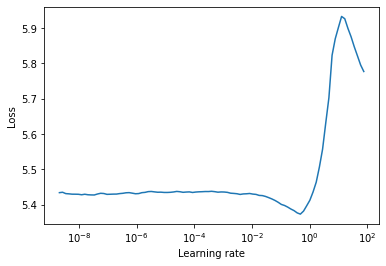

In [0]:
import plot_lr as pltr
ax=pltr.plot(history,plt) 
ax # PLot the LR graph       

In [0]:
print("The best learning rate obtained is ",best_lr)

The best learning rate obtained is  0.4786300923226384


In [0]:
net1=test().to('cuda')   

In [0]:
import train_test_model_resnet18_missclass as t1   #import train - test module .This is class to train and evaluate the model
import numpy as np                                
train_losses = []
best_lr=0.08
test_acc = []
test_losses = []
train_acc = []
train_loss_graph=[]
train_acc_graph=[]
test_acc_graph=[]
test_loss_graph=[]
optimizer = optim.SGD(net.parameters(),lr=best_lr,weight_decay=0.001,momentum=0.90)
criterion=nn.CrossEntropyLoss()
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=np.sqrt(0.1),patience=5,min_lr=0.000001)
#scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
#optimizer=optim.Adam(model.parameters(), lr=0.045, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
EPOCHS = 50
device='cuda'
#device='cpu'
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_loss,train_acc1=t1.train(net, device, trainloader, optimizer, epoch,train_losses,train_acc,tqdm,criterion)
    train_loss_graph.append(train_loss)
    train_acc_graph.append(train_acc1)
    test_loss,test_acc1=t1.test(net, device, testloader,test_losses,test_acc,tqdm,criterion,torch)
    test_loss_graph.append(test_loss)
    test_acc_graph.append(test_acc1)
    scheduler.step(test_loss)
    

  0%|          | 0/137 [00:00<?, ?it/s]

EPOCH: 0


Loss=5.3178181648254395 Batch_id=9 Accuracy=1.11:   7%|▋         | 10/137 [19:40<3:31:31, 99.93s/it]

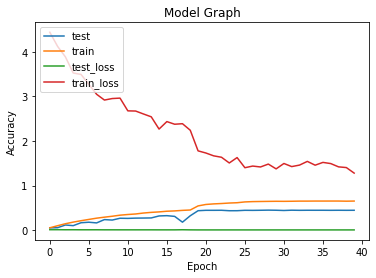

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(test_acc_graph)                
plt.plot(train_acc_graph)
plt.plot(test_loss_graph)   
plt.plot(train_loss_graph)       
plt.title("Model Graph")          
plt.ylabel('Accuracy')
plt.xlabel('Epoch')               
plt.legend(['test','train','test_loss','train_loss'] ,loc='upper left')
plt.show()  
plt.savefig('Upload_graph.png')                                          

In [0]:
cam2=[]          
data2=[]
k=[]
dat=[]
number=0
p=[]
l=[]
data2=[]
for im in range(25):
  
  dat1,label = next(iter(testloader))
  dat1=dat1.to('cuda')
  output=net(dat1)
  pred = output.argmax(dim=1, keepdim=True)
  
  for i in range(label.size()[0]):
   if pred[i].item() != label[i].item():
    p.append(pred[i].item()) 
    l.append(label[i].item()) 
    label1=label[i]
    data1=dat1[i]
    data2.append(dat1[i].to('cpu'))
    label1=label1.unsqueeze(0) 
    Gd1=gd.GradCm()
    cam1=Gd1.img(data1,label1,net)
    cam2.append(cam1) 
    number = len(cam2)
    if number >= 25:
        print(number)
        break
  else:
   continue
  break 

In [0]:
plott=pt.Plot()
#l=l.to('cpu')
#data2=data2.to('cpu')
plott.fig(data2,cam2,l,p)
